In [6]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import pyshark
from struct import pack
from xdrlib import Packer  
import nest_asyncio
nest_asyncio.apply()


In [8]:
# from struct import pack
# from xdrlib import Packer
pcapfile = "./Data1.pcap"


Data = pyshark.FileCapture(pcapfile, keep_packets=False)

rows = []
for packet in Data:
    try:
        ts = float (packet.frame_info.timestamp)
    except AttributeError:
        ts = None

    proto = packet.highest_layer
    length = int(packet.length)
    src = packet.ip.src if hasattr (packet, 'ip') else (packet.eth.src if hasattr (packet, 'eth') else None)
    dst = packet.ip.dst if hasattr (packet, 'ip') else (packet.eth.dst if hasattr (packet, 'eth') else None)

    rows.append({'time': ts , 'proto': proto, 'length': length, 'src': src, 'dst': dst})

Data.close()

df = pd.DataFrame(rows)
df['time'] = pd.to_datetime(df['time'], unit='s')
df

,time,proto,length,src,dst
0,NaT,STP,60,80:e8:6f:4b:17:87,01:80:c2:00:00:00
1,NaT,TLS,90,185.75.135.224,192.168.125.114
2,NaT,TCP,54,192.168.125.114,185.75.135.224
3,NaT,TCP,66,185.75.135.224,192.168.125.114
4,NaT,TCP,54,192.168.125.114,185.75.135.224
...,...,...,...,...,...
50535,NaT,TCP,66,192.168.125.114,104.18.18.125
50536,NaT,TLS,101,104.18.18.125,192.168.125.114
50537,NaT,TCP,66,192.168.125.114,104.18.18.125
50538,NaT,TLS,147,104.18.18.125,192.168.125.114


In [ ]:
print("Packet Counts= ", len(df))
print('Protocol Counts:\n ', df['proto'].value_counts())
print ('==================================')
# بیشترین مقاصد و مبدا ها
print('Top Source IPs: \n', df['src'].value_counts().head())
 


Packet Counts=  50540
Protocol Counts:
  proto
TCP        33945
HTTP        8233
TLS         6599
SOCKS        459
STP          412
DNS          372
DATA         204
QUIC         152
ARP           54
DTP           28
SSDP          28
CDP           15
MNDP          14
MDNS          12
BROWSER        5
ICMPV6         2
MEDIA          2
NBNS           2
DHCP           2
Name: count, dtype: int64
TopSource IPs: 
 src
192.168.125.114    23185
217.26.222.222     15554
151.101.64.223      4227
185.75.135.224      2175
172.64.155.209       835
Name: count, dtype: int64
Top Destination IPs: 
 dst
192.168.125.114    26715
217.26.222.222     12549
185.75.135.224      2929
151.101.64.223      2643
104.18.18.125        838
Name: count, dtype: int64


In [29]:
print('Top Destination IPs: \n', df['dst'].value_counts().head())
##### Packet Size by IP
print('========================================')
print('========================================')
bytes_by_dst = df.groupby('dst')['length'].sum().sort_values(ascending=False).head()
print ('Top Destination By Total Bytes: \n', bytes_by_dst)


Top Destination IPs: 
 dst
192.168.125.114    26715
217.26.222.222     12549
185.75.135.224      2929
151.101.64.223      2643
104.18.18.125        838
Name: count, dtype: int64
Top Destination By Total Bytes: 
 dst
192.168.125.114    39021001
217.26.222.222       932703
185.75.135.224       708305
172.64.155.209       645175
151.101.64.223       209045
Name: length, dtype: int64


In [32]:
####### Plot Packets per time
# df1 = df
# df1.dropna()
# df1.set_index('time', inplace=True)
# pkt_rate= df['proto'].resample('10S').count()
# pkt_rate.plot(title='Packet oer 10S ')
# plt.xlabel='Time'
# plt.ylabel='Packet Count'
# plt.grid()
# plt.show()


In [33]:
flows = df.reset_index().groupby(['src','dst','proto']).agg(
    packet_count=('length','count'),
    total_bytes=('length','sum')
).sort_values('total_bytes', ascending=False).head(20)

print(flows)

                                       packet_count  total_bytes
src             dst             proto                           
217.26.222.222  192.168.125.114 HTTP           8220     15418382
                                TCP            7329     12355743
151.101.64.223  192.168.125.114 TCP            2211      3643828
                                TLS            1962      3561461
192.168.125.114 217.26.222.222  TCP           12541       929434
185.75.135.224  192.168.125.114 TLS             549       577240
                                TCP            1619       468071
192.168.125.114 185.75.135.224  TLS             625       460020
                172.64.155.209  TLS             232       450367
151.101.0.223   192.168.125.114 TLS             279       446430
140.82.121.6    192.168.125.114 TLS             226       307076
91.98.144.125   192.168.125.114 SOCKS           311       293012
151.101.0.223   192.168.125.114 TCP             174       269092
192.168.125.114 185.75.13

<AxesSubplot: title={'center': 'Protocol Distribution'}, xlabel='proto'>

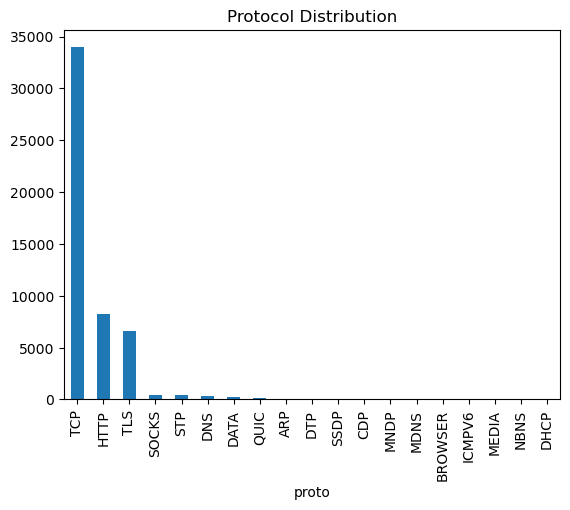

In [34]:
df['proto'].value_counts().plot(kind='bar', title='Protocol Distribution')


<AxesSubplot: title={'center': 'Top 10 Source IPs'}, xlabel='src'>

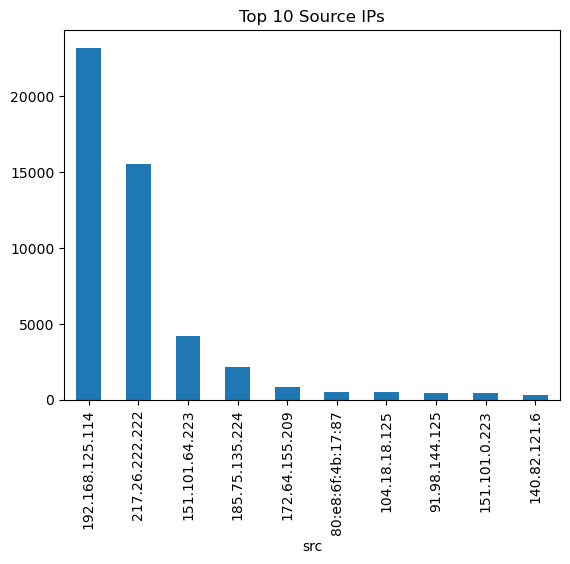

In [36]:
df['src'].value_counts().head(10).plot(kind='bar', title='Top 10 Source IPs')




<AxesSubplot: title={'center': 'Top 10 Destination IPs'}, xlabel='dst'>

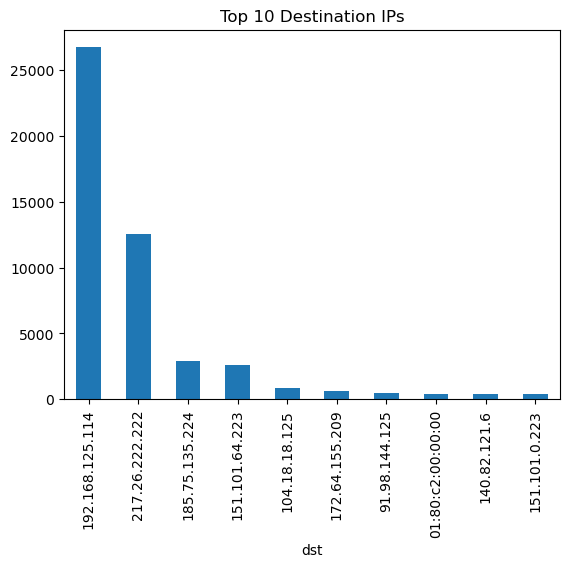

In [37]:
df['dst'].value_counts().head(10).plot(kind='bar', title='Top 10 Destination IPs')

In [ ]:
# pkt_rate = df['proto'].resample('10S').count()  # هر 10 ثانیه
# pkt_rate.plot(title='Packet Count per 10s')


AttributeError: 'NaTType' object has no attribute 'normalize'

In [39]:
df1.to_csv('/home/omid/Documents/Programming/network-Analysis/Network-Traffic/output.csv', index=False)

<AxesSubplot: title={'center': 'Top 10 Destinations by Total Bytes'}, xlabel='dst'>

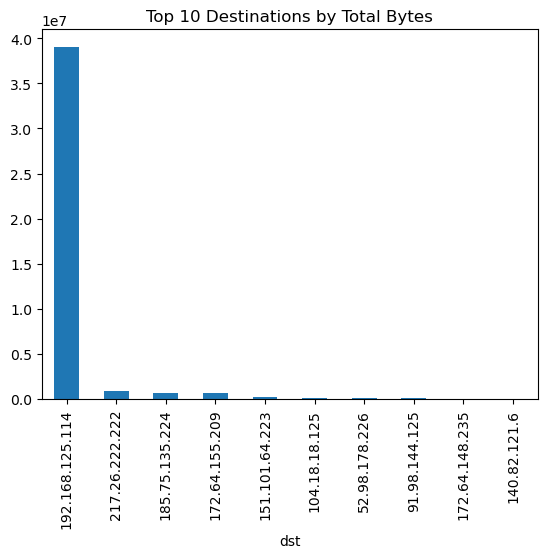

In [40]:
df.groupby('dst')['length'].sum().sort_values(ascending=False).head(10).plot(kind='bar', title='Top 10 Destinations by Total Bytes')


<AxesSubplot: xlabel='dst', ylabel='src'>

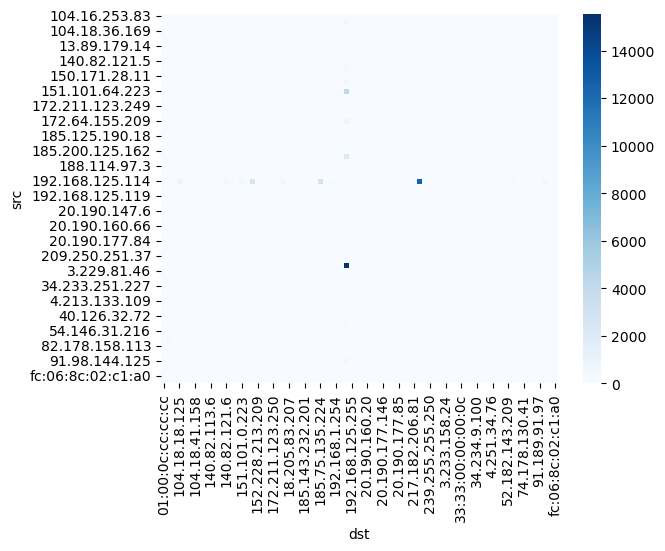

In [41]:
# import seaborn as sns
flow_matrix = df.groupby(['src','dst']).size().unstack(fill_value=0)
sns.heatmap(flow_matrix, cmap='Blues')
